In [ ]:
!pip install datasets transformers
!pip install mecab-python3
!pip install unidic
!python -m unidic download
!pip install pandarallel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.2/591.2 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for unidic: filename=unidic-1.1.0-py3-none-any.whl size=7403 sha256=eff0413ba0380986069602f31718b7cb11a5fc3ab92e23a3fd18f4a1f3244385
  Stored in directory: /root/.cache/pip/wheels/cb/04/a2/659428f84ed1fa7257f8efb544b36043dd37a7c419e8ca711a
Successfully built unidic
  Attempting uninstall: wasabi
    Found existing installation: wasabi 1.1.3
    Uninstalling wasabi-1.1.3:
      Successfully uninstalled wasabi-1.1.3
download url: https://cotonoha-dic.s3-ap-northeast-1.amazonaws.com/unidic-3.1.0.zip
Dictionary version: 3.1.0+2021-08-31
unidic-3.1.0.zip: 100% 526M/526M [00:24<00:00, 21.7MB/s]
Finished download.
Downloaded UniDic v3.1.0+2021-08-31 to /usr/local/lib/python3.12/dist-packages/unidic/dicdir
  Preparing metadata (setup.py) ... done
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=c1f652ba61047b539b7

In [ ]:
from torch import nn
import datasets
import transformers
import torch
import pandas as pd

import time
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')

from nltk import bleu_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import MeCab
import unidic

# wakati = MeCab.Tagger('-Owakati')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(1)
random_state = 42

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#"""
from datasets import load_dataset
#dataset = datasets.load_dataset('wmt14', 'de-en')
# --- Replaced: use a stable EN-JA dataset (OPUS100) instead of Helsinki-NLP/tatoeba_mt ---
# OPUS100 provides 'train'/'validation'/'test' splits with a 'translation' field {'en': ..., 'ja': ...}.
dataset = load_dataset("opus100", "en-ja")

# Use official splits. If 'test' split is unavailable in some mirrors, fall back to 'validation' as test.
train = dataset["train"]
test = dataset["test"] if "test" in dataset else dataset["validation"]

# Build DataFrames with the same columns as before: src (EN), tgt (JA)
train_df = pd.DataFrame(train["translation"]).rename(columns={"en": "src", "ja": "tgt"})
test_df  = pd.DataFrame(test["translation"]).rename(columns={"en": "src", "ja": "tgt"})

#train = dataset["train"]["translation"]
#test = dataset["test"]["translation"]

#train_df = pd.DataFrame(train)
#test_df = pd.DataFrame(test)

train_df.columns = ["tgt", "src"]
test_df.columns = ["tgt", "src"]

#src_tokenize = lambda text:  " ".join(nltk.tokenize.word_tokenize(text))
#tgt_tokenize = lambda text:  " ".join(nltk.tokenize.word_tokenize(text))
#"""

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-ja/test-00000-of-00001.parquet:   0%|          | 0.00/140k [00:00<?, ?B/s]

en-ja/train-00000-of-00001.parquet:   0%|          | 0.00/64.5M [00:00<?, ?B/s]

en-ja/validation-00000-of-00001.parquet:   0%|          | 0.00/140k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
"""
dataset = datasets.load_dataset('mteb/tatoeba-bitext-mining', 'jpn-eng')

train_df = pd.DataFrame(dataset["test"])

test_df = train_df.iloc[900:]
train_df = train_df.iloc[:900]

train_df.columns = ["tgt", "src"]
test_df.columns = ["tgt", "src"]

src_tokenize = lambda text:  " ".join(nltk.tokenize.word_tokenize(text))
tgt_tokenize = lambda text:  wakati.parse(text)
"""

'\ndataset = datasets.load_dataset(\'mteb/tatoeba-bitext-mining\', \'jpn-eng\')\n\ntrain_df = pd.DataFrame(dataset["test"])\n\ntest_df = train_df.iloc[900:]\ntrain_df = train_df.iloc[:900]\n\ntrain_df.columns = ["tgt", "src"]\ntest_df.columns = ["tgt", "src"]\n\nsrc_tokenize = lambda text:  " ".join(nltk.tokenize.word_tokenize(text))\ntgt_tokenize = lambda text:  wakati.parse(text)\n'

In [ ]:
"""
import os
os.environ["HF_DATASETS_TRUST_REMOTE_CODE"] = "1"

#from huggingface_hub import login
#login()
os.environ["HF_TOKEN"] = "  "

from datasets import load_dataset

dataset = load_dataset(
    "Helsinki-NLP/tatoeba_mt",
    #"eng-jpn",
    revision="refs/convert/parquet",  # 해당 브랜치/리비전이 존재할 때만
    token=os.environ["HF_TOKEN"]          # 최신 버전 파라미터명: token
    # (구버전은 use_auth_token=os.environ["HF_TOKEN"])

)

#dataset = datasets.load_dataset('Helsinki-NLP/tatoeba_mt', 'eng-jpn_Hira', ignore_verifications=True)
#dataset = datasets.load_dataset("ted_multi", "ja-en")
#train_df = pd.DataFrame(dataset["train"])

# 컬럼 이름 확인(환경마다 다를 수 있으니 먼저 출력해 보세요)
#print(dataset["train"].column_names)

# 예시: sourceLang == 'eng' & targetLang == 'jpn'만 사용
train = dataset["train"].filter(lambda x: x["sourceLang"]=="eng" and x["targetLang"]=="jpn")
test  = dataset["test"].filter(lambda x: x["sourceLang"]=="eng" and x["targetLang"]=="jpn")

#train = dataset["train"]
#test = dataset["test"]

train_df = pd.DataFrame(train)
test_df = pd.DataFrame(test)

train_df = train_df.drop(["sourceLang", "targetlang"], axis=1)
train_df.columns = ["src", "tgt"]

test_df = test_df.drop(["sourceLang", "targetlang"], axis=1)
test_df.columns = ["src", "tgt"]

src_tokenize = lambda text:  " ".join(nltk.tokenize.word_tokenize(text))
tgt_tokenize = lambda text:  wakati.parse(text)
"""

Resolving data files:   0%|          | 0/394 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/783 [00:00<?, ?it/s]

ita-zho/test/0000.parquet:   0%|          | 0.00/125k [00:00<?, ?B/s]

jbo_Latn-cmn_Hans/test/0000.parquet:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

jpn-jpn/test/0000.parquet:   0%|          | 0.00/42.8k [00:00<?, ?B/s]

jpn-msa/test/0000.parquet:   0%|          | 0.00/137k [00:00<?, ?B/s]

jpn-nds/test/0000.parquet:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

jpn-mar/test/0000.parquet:   0%|          | 0.00/20.5k [00:00<?, ?B/s]

jpn-kor/test/0000.parquet:   0%|          | 0.00/38.5k [00:00<?, ?B/s]

jbo_Latn-jpn_Hira/test/0000.parquet:   0%|          | 0.00/38.7k [00:00<?, ?B/s]

jpn-nld/test/0000.parquet:   0%|          | 0.00/176k [00:00<?, ?B/s]

jpn-rus/test/0000.parquet:   0%|          | 0.00/662k [00:00<?, ?B/s]

jpn-lit/test/0000.parquet:   0%|          | 0.00/15.6k [00:00<?, ?B/s]

jpn-pol/test/0000.parquet:   0%|          | 0.00/624k [00:00<?, ?B/s]

jpn-por/test/0000.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

jpn-spa/test/0000.parquet:   0%|          | 0.00/608k [00:00<?, ?B/s]

jbo_Latn-cmn_Hant/test/0000.parquet:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

jpn-nor/test/0000.parquet:   0%|          | 0.00/64.8k [00:00<?, ?B/s]

jpn-ukr/test/0000.parquet:   0%|          | 0.00/29.1k [00:00<?, ?B/s]

jpn-tlh/test/0000.parquet:   0%|          | 0.00/36.7k [00:00<?, ?B/s]

jpn-toki/test/0000.parquet:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

jpn-swe/test/0000.parquet:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

jpn_Hani-nld/test/0000.parquet:   0%|          | 0.00/23.2k [00:00<?, ?B/s]

jpn_Hani-cmn_Hans/test/0000.parquet:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

jpn-zho/test/0000.parquet:   0%|          | 0.00/143k [00:00<?, ?B/s]

jpn_Hani-rus/test/0000.parquet:   0%|          | 0.00/57.1k [00:00<?, ?B/s]

jpn_Hira-cmn_Hans/test/0000.parquet:   0%|          | 0.00/74.4k [00:00<?, ?B/s]

jpn_Hani-por/test/0000.parquet:   0%|          | 0.00/22.2k [00:00<?, ?B/s]

jpn_Hani-pol/test/0000.parquet:   0%|          | 0.00/69.1k [00:00<?, ?B/s]

jpn-tur/test/0000.parquet:   0%|          | 0.00/49.6k [00:00<?, ?B/s]

jpn_Hira-cmn_Hant/test/0000.parquet:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

jpn_Hani-spa/test/0000.parquet:   0%|          | 0.00/64.4k [00:00<?, ?B/s]

jpn_Hira-jpn_Hira/test/0000.parquet:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

jpn_Hira-ind/test/0000.parquet:   0%|          | 0.00/117k [00:00<?, ?B/s]

jpn_Hira-kor_Hang/test/0000.parquet:   0%|          | 0.00/32.8k [00:00<?, ?B/s]

jpn_Hira-nds/test/0000.parquet:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

jpn_Hira-lit/test/0000.parquet:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

jpn_Hira-rus/test/0000.parquet:   0%|          | 0.00/586k [00:00<?, ?B/s]

jpn_Hira-por/test/0000.parquet:   0%|          | 0.00/96.1k [00:00<?, ?B/s]

jpn_Hira-nld/test/0000.parquet:   0%|          | 0.00/149k [00:00<?, ?B/s]

jpn_Hira-swe/test/0000.parquet:   0%|          | 0.00/41.7k [00:00<?, ?B/s]

jpn_Hira-mar/test/0000.parquet:   0%|          | 0.00/15.2k [00:00<?, ?B/s]

jpn_Hira-spa/test/0000.parquet:   0%|          | 0.00/533k [00:00<?, ?B/s]

jpn_Hira-pol/test/0000.parquet:   0%|          | 0.00/548k [00:00<?, ?B/s]

jpn_Hira-nob/test/0000.parquet:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

jpn_Hira-ukr/test/0000.parquet:   0%|          | 0.00/25.6k [00:00<?, ?B/s]

jpn_Kana-rus/test/0000.parquet:   0%|          | 0.00/24.5k [00:00<?, ?B/s]

jpn_Hira-tur/test/0000.parquet:   0%|          | 0.00/45.3k [00:00<?, ?B/s]

jpn_Hira-tlh_Latn/test/0000.parquet:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

jpn_Kana-spa/test/0000.parquet:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

kaz_Cyrl-rus/test/0000.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

kor-spa/test/0000.parquet:   0%|          | 0.00/51.8k [00:00<?, ?B/s]

kab-kab/test/0000.parquet:   0%|          | 0.00/41.2k [00:00<?, ?B/s]

kab-rus/test/0000.parquet:   0%|          | 0.00/22.0k [00:00<?, ?B/s]

kab-spa/test/0000.parquet:   0%|          | 0.00/46.3k [00:00<?, ?B/s]

kor-rus/test/0000.parquet:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

khm-spa/test/0000.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

kaz-rus/test/0000.parquet:   0%|          | 0.00/181k [00:00<?, ?B/s]

kor_Hang-cmn_Hans/test/0000.parquet:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

kat-rus/test/0000.parquet:   0%|          | 0.00/41.4k [00:00<?, ?B/s]

kor_Hang-rus/test/0000.parquet:   0%|          | 0.00/15.9k [00:00<?, ?B/s]

kor-zho/test/0000.parquet:   0%|          | 0.00/24.8k [00:00<?, ?B/s]

kor_Hang-spa/test/0000.parquet:   0%|          | 0.00/51.3k [00:00<?, ?B/s]

kzj-msa/test/0000.parquet:   0%|          | 0.00/29.5k [00:00<?, ?B/s]

kzj_Latn-zsm_Latn/test/0000.parquet:   0%|          | 0.00/28.2k [00:00<?, ?B/s]

lad-yid/test/0000.parquet:   0%|          | 0.00/20.1k [00:00<?, ?B/s]

lad_Latn-lfn_Latn/test/0000.parquet:   0%|          | 0.00/8.61k [00:00<?, ?B/s]

lad-lfn/test/0000.parquet:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

lad-spa/test/0000.parquet:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

lad_Latn-yid/test/0000.parquet:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

lat-rus/test/0000.parquet:   0%|          | 0.00/55.0k [00:00<?, ?B/s]

lat-tlh/test/0000.parquet:   0%|          | 0.00/9.81k [00:00<?, ?B/s]

lat-lfn/test/0000.parquet:   0%|          | 0.00/13.0k [00:00<?, ?B/s]

lat-pol/test/0000.parquet:   0%|          | 0.00/37.9k [00:00<?, ?B/s]

lat-lat/test/0000.parquet:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

lad-lat/test/0000.parquet:   0%|          | 0.00/8.60k [00:00<?, ?B/s]

lat-nld/test/0000.parquet:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

lad_Latn-spa/test/0000.parquet:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

lat-nor/test/0000.parquet:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

lat-ukr/test/0000.parquet:   0%|          | 0.00/19.8k [00:00<?, ?B/s]

lat-yid/test/0000.parquet:   0%|          | 0.00/18.8k [00:00<?, ?B/s]

lat_Latn-lfn_Latn/test/0000.parquet:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

lfn-spa/test/0000.parquet:   0%|          | 0.00/14.4k [00:00<?, ?B/s]

lav-rus/test/0000.parquet:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

lfn-rus/test/0000.parquet:   0%|          | 0.00/14.5k [00:00<?, ?B/s]

lit-tur/test/0000.parquet:   0%|          | 0.00/63.6k [00:00<?, ?B/s]

lfn-yid/test/0000.parquet:   0%|          | 0.00/38.4k [00:00<?, ?B/s]

lit-rus/test/0000.parquet:   0%|          | 0.00/185k [00:00<?, ?B/s]

lfn_Latn-yid/test/0000.parquet:   0%|          | 0.00/34.8k [00:00<?, ?B/s]

lit-spa/test/0000.parquet:   0%|          | 0.00/21.5k [00:00<?, ?B/s]

lit-pol/test/0000.parquet:   0%|          | 0.00/85.2k [00:00<?, ?B/s]

lfn_Cyrl-por/test/0000.parquet:   0%|          | 0.00/19.7k [00:00<?, ?B/s]

msa-spa/test/0000.parquet:   0%|          | 0.00/13.6k [00:00<?, ?B/s]

ltz-nld/test/0000.parquet:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

mkd-spa/test/0000.parquet:   0%|          | 0.00/11.4k [00:00<?, ?B/s]

msa-msa/test/0000.parquet:   0%|          | 0.00/48.2k [00:00<?, ?B/s]

msa-zho/test/0000.parquet:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

nds-nld/test/0000.parquet:   0%|          | 0.00/77.3k [00:00<?, ?B/s]

nds-por/test/0000.parquet:   0%|          | 0.00/11.3k [00:00<?, ?B/s]

nds-rus/test/0000.parquet:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

nld-pol/test/0000.parquet:   0%|          | 0.00/62.1k [00:00<?, ?B/s]

nld-nld/test/0000.parquet:   0%|          | 0.00/50.0k [00:00<?, ?B/s]

nld-rus/test/0000.parquet:   0%|          | 0.00/143k [00:00<?, ?B/s]

nld-nor/test/0000.parquet:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

nds-spa/test/0000.parquet:   0%|          | 0.00/39.1k [00:00<?, ?B/s]

nld-por/test/0000.parquet:   0%|          | 0.00/123k [00:00<?, ?B/s]

nld-toki/test/0000.parquet:   0%|          | 0.00/19.5k [00:00<?, ?B/s]

nld-cmn_Hant/test/0000.parquet:   0%|          | 0.00/86.1k [00:00<?, ?B/s]

nld-ron/test/0000.parquet:   0%|          | 0.00/113k [00:00<?, ?B/s]

nld-tur/test/0000.parquet:   0%|          | 0.00/122k [00:00<?, ?B/s]

nld-ukr/test/0000.parquet:   0%|          | 0.00/384k [00:00<?, ?B/s]

nld-zho/test/0000.parquet:   0%|          | 0.00/93.0k [00:00<?, ?B/s]

nno-nob/test/0000.parquet:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

nor-nor/test/0000.parquet:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

nor-por/test/0000.parquet:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

nor-rus/test/0000.parquet:   0%|          | 0.00/97.3k [00:00<?, ?B/s]

nob-nno/test/0000.parquet:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

orv-ukr/test/0000.parquet:   0%|          | 0.00/47.4k [00:00<?, ?B/s]

nob-spa/test/0000.parquet:   0%|          | 0.00/48.6k [00:00<?, ?B/s]

nob-swe/test/0000.parquet:   0%|          | 0.00/27.4k [00:00<?, ?B/s]

nor-ukr/test/0000.parquet:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

nor-spa/test/0000.parquet:   0%|          | 0.00/51.4k [00:00<?, ?B/s]

ota-tur/test/0000.parquet:   0%|          | 0.00/15.4k [00:00<?, ?B/s]

nor-pol/test/0000.parquet:   0%|          | 0.00/17.9k [00:00<?, ?B/s]

pol-cmn_Hans/test/0000.parquet:   0%|          | 0.00/23.0k [00:00<?, ?B/s]

pol-cmn_Hant/test/0000.parquet:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

pol-por/test/0000.parquet:   0%|          | 0.00/41.0k [00:00<?, ?B/s]

pol-rus/test/0000.parquet:   0%|          | 0.00/199k [00:00<?, ?B/s]

por-swe/test/0000.parquet:   0%|          | 0.00/17.1k [00:00<?, ?B/s]

pol-ukr/test/0000.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

por-por/test/0000.parquet:   0%|          | 0.00/120k [00:00<?, ?B/s]

pol-zho/test/0000.parquet:   0%|          | 0.00/58.9k [00:00<?, ?B/s]

por-cmn_Hans/test/0000.parquet:   0%|          | 0.00/32.4k [00:00<?, ?B/s]

por-ron/test/0000.parquet:   0%|          | 0.00/35.0k [00:00<?, ?B/s]

pol-tur/test/0000.parquet:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

por-cmn_Hant/test/0000.parquet:   0%|          | 0.00/18.5k [00:00<?, ?B/s]

pol-swe/test/0000.parquet:   0%|          | 0.00/70.2k [00:00<?, ?B/s]

por-rus/test/0000.parquet:   0%|          | 0.00/569k [00:00<?, ?B/s]

por-tgl/test/0000.parquet:   0%|          | 0.00/92.7k [00:00<?, ?B/s]

por-toki/test/0000.parquet:   0%|          | 0.00/83.1k [00:00<?, ?B/s]

por-tur/test/0000.parquet:   0%|          | 0.00/84.2k [00:00<?, ?B/s]

ron-tur/test/0000.parquet:   0%|          | 0.00/132k [00:00<?, ?B/s]

por-ukr/test/0000.parquet:   0%|          | 0.00/160k [00:00<?, ?B/s]

run-rus/test/0000.parquet:   0%|          | 0.00/42.3k [00:00<?, ?B/s]

ron-rus/test/0000.parquet:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

rus-cmn_Hans/test/0000.parquet:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

rus-cmn_Hant/test/0000.parquet:   0%|          | 0.00/45.2k [00:00<?, ?B/s]

rus-slv/test/0000.parquet:   0%|          | 0.00/36.5k [00:00<?, ?B/s]

rus-sah/test/0000.parquet:   0%|          | 0.00/62.3k [00:00<?, ?B/s]

rus-rus/test/0000.parquet:   0%|          | 0.00/164k [00:00<?, ?B/s]

rus-swe/test/0000.parquet:   0%|          | 0.00/66.1k [00:00<?, ?B/s]

rus-tlh/test/0000.parquet:   0%|          | 0.00/12.8k [00:00<?, ?B/s]

rus-toki_Latn/test/0000.parquet:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

rus-toki/test/0000.parquet:   0%|          | 0.00/43.8k [00:00<?, ?B/s]

rus-uig/test/0000.parquet:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

rus-uig_Arab/test/0000.parquet:   0%|          | 0.00/34.6k [00:00<?, ?B/s]

rus-ukr/test/0000.parquet:   0%|          | 0.00/567k [00:00<?, ?B/s]

rus-zho/test/0000.parquet:   0%|          | 0.00/151k [00:00<?, ?B/s]

slv-zho/test/0000.parquet:   0%|          | 0.00/42.1k [00:00<?, ?B/s]

slv-cmn_Hans/test/0000.parquet:   0%|          | 0.00/38.1k [00:00<?, ?B/s]

spa-cmn_Hans/test/0000.parquet:   0%|          | 0.00/54.4k [00:00<?, ?B/s]

nor-swe/test/0000.parquet:   0%|          | 0.00/27.5k [00:00<?, ?B/s]

spa-cmn_Hant/test/0000.parquet:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

rus-xal/test/0000.parquet:   0%|          | 0.00/16.2k [00:00<?, ?B/s]

por-zho/test/0000.parquet:   0%|          | 0.00/49.2k [00:00<?, ?B/s]

slv-ukr/test/0000.parquet:   0%|          | 0.00/35.8k [00:00<?, ?B/s]

spa-spa/test/0000.parquet:   0%|          | 0.00/153k [00:00<?, ?B/s]

rus-vie/test/0000.parquet:   0%|          | 0.00/23.3k [00:00<?, ?B/s]

spa-swe/test/0000.parquet:   0%|          | 0.00/60.9k [00:00<?, ?B/s]

spa-tat/test/0000.parquet:   0%|          | 0.00/19.4k [00:00<?, ?B/s]

spa-vie/test/0000.parquet:   0%|          | 0.00/31.4k [00:00<?, ?B/s]

spa-tgl/test/0000.parquet:   0%|          | 0.00/34.9k [00:00<?, ?B/s]

spa-tlh/test/0000.parquet:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

spa-yid/test/0000.parquet:   0%|          | 0.00/20.7k [00:00<?, ?B/s]

nob-rus/test/0000.parquet:   0%|          | 0.00/97.2k [00:00<?, ?B/s]

spa-toki/test/0000.parquet:   0%|          | 0.00/26.9k [00:00<?, ?B/s]

spa-tur/test/0000.parquet:   0%|          | 0.00/444k [00:00<?, ?B/s]

spa-ukr/test/0000.parquet:   0%|          | 0.00/436k [00:00<?, ?B/s]

spa-zho/test/0000.parquet:   0%|          | 0.00/124k [00:00<?, ?B/s]

srp_Cyrl-rus/test/0000.parquet:   0%|          | 0.00/53.0k [00:00<?, ?B/s]

srp_Cyrl-ukr/test/0000.parquet:   0%|          | 0.00/12.4k [00:00<?, ?B/s]

srp_Latn-nob/test/0000.parquet:   0%|          | 0.00/293k [00:00<?, ?B/s]

srp_Latn-ukr/test/0000.parquet:   0%|          | 0.00/16.6k [00:00<?, ?B/s]

srp_Latn-ita/test/0000.parquet:   0%|          | 0.00/11.6k [00:00<?, ?B/s]

srp_Latn-rus/test/0000.parquet:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

swe-cmn_Hant/test/0000.parquet:   0%|          | 0.00/21.3k [00:00<?, ?B/s]

swe-swe/test/0000.parquet:   0%|          | 0.00/45.5k [00:00<?, ?B/s]

swe-cmn_Hans/test/0000.parquet:   0%|          | 0.00/21.2k [00:00<?, ?B/s]

swe-zho/test/0000.parquet:   0%|          | 0.00/40.7k [00:00<?, ?B/s]

tlh-yid/test/0000.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

swe-tur/test/0000.parquet:   0%|          | 0.00/12.7k [00:00<?, ?B/s]

tat-tur/test/0000.parquet:   0%|          | 0.00/29.9k [00:00<?, ?B/s]

tat-vie/test/0000.parquet:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

tlh-zho/test/0000.parquet:   0%|          | 0.00/21.1k [00:00<?, ?B/s]

tlh_Latn-cmn_Hant/test/0000.parquet:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

tlh_Latn-cmn_Hans/test/0000.parquet:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

tlh_Latn-yid/test/0000.parquet:   0%|          | 0.00/11.9k [00:00<?, ?B/s]

tur-tur/test/0000.parquet:   0%|          | 0.00/108k [00:00<?, ?B/s]

run-spa/test/0000.parquet:   0%|          | 0.00/30.6k [00:00<?, ?B/s]

tur-uig/test/0000.parquet:   0%|          | 0.00/85.1k [00:00<?, ?B/s]

tur-cmn_Hant/test/0000.parquet:   0%|          | 0.00/18.4k [00:00<?, ?B/s]

tur-cmn_Hans/test/0000.parquet:   0%|          | 0.00/26.6k [00:00<?, ?B/s]

tur-ukr/test/0000.parquet:   0%|          | 0.00/111k [00:00<?, ?B/s]

uig-zho/test/0000.parquet:   0%|          | 0.00/105k [00:00<?, ?B/s]

tur-zho/test/0000.parquet:   0%|          | 0.00/41.3k [00:00<?, ?B/s]

tur-uzb/test/0000.parquet:   0%|          | 0.00/11.8k [00:00<?, ?B/s]

uig_Arab-cmn_Hans/test/0000.parquet:   0%|          | 0.00/78.5k [00:00<?, ?B/s]

ukr-ukr/test/0000.parquet:   0%|          | 0.00/39.4k [00:00<?, ?B/s]

vie-vie/test/0000.parquet:   0%|          | 0.00/38.3k [00:00<?, ?B/s]

ukr-cmn_Hant/test/0000.parquet:   0%|          | 0.00/25.4k [00:00<?, ?B/s]

uig_Arab-cmn_Hant/test/0000.parquet:   0%|          | 0.00/30.5k [00:00<?, ?B/s]

vie-zho/test/0000.parquet:   0%|          | 0.00/29.7k [00:00<?, ?B/s]

ukr-zho/test/0000.parquet:   0%|          | 0.00/79.7k [00:00<?, ?B/s]

vie-cmn_Hans/test/0000.parquet:   0%|          | 0.00/25.9k [00:00<?, ?B/s]

ukr-cmn_Hans/test/0000.parquet:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

yid-yid/test/0000.parquet:   0%|          | 0.00/17.5k [00:00<?, ?B/s]

wuu-cmn_Hans/test/0000.parquet:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

zsm_Latn-ind/test/0000.parquet:   0%|          | 0.00/18.3k [00:00<?, ?B/s]

zho-zho/test/0000.parquet:   0%|          | 0.00/180k [00:00<?, ?B/s]

rus-yue_Hans/test/0000.parquet:   0%|          | 0.00/16.1k [00:00<?, ?B/s]

HfHubHTTPError: 502 Server Error: Bad Gateway for url: https://huggingface.co/api/datasets/Helsinki-NLP/tatoeba_mt/xet-read-token/f0b1ed578baae4c5de25a481684cdbd21d5c40d5

In [ ]:
# Ensure NLTK tokenizers are available in all worker processes
try:
    import nltk
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    # Required by newer NLTK versions for sentence tokenization tables
    nltk.download('punkt_tab')

# Do NOT keep a global MeCab.Tagger for multiprocessing; create per call instead.
def tgt_tokenize(text: str) -> str:
    tagger = MeCab.Tagger('-Owakati')
    return tagger.parse(text)

# English: use NLTK word_tokenize (now that punkt/punkt_tab are ensured)
src_tokenize = lambda text: " ".join(nltk.tokenize.word_tokenize(text))

# parallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)  # workers=1 환경이면 그대로 둬도 됩니다.

MAX_TRAIN = 25000
MAX_TEST  = 2500

src = train_df.src.parallel_apply(src_tokenize)
tgt = train_df.tgt.parallel_apply(tgt_tokenize)
train_df = pd.concat([src, tgt], axis=1)
train_df = train_df.iloc[:MAX_TRAIN].reset_index(drop=True)
train_df.columns = ["src", "tgt"]

src = test_df.src.parallel_apply(src_tokenize)
tgt = test_df.tgt.parallel_apply(tgt_tokenize)
test_df = pd.concat([src, tgt], axis=1)
test_df  = test_df.iloc[:MAX_TEST].reset_index(drop=True)
test_df.columns = ["src", "tgt"]


'''
# parallel
from pandarallel import pandarallel
pandarallel.initialize()

src = train_df.src.parallel_apply(src_tokenize)
tgt = train_df.tgt.parallel_apply(tgt_tokenize)
train_df = pd.concat([src, tgt], axis=1)
train_df.columns = ["src", "tgt"]
print(train_df)

src = test_df.src.parallel_apply(src_tokenize)
tgt = test_df.tgt.parallel_apply(tgt_tokenize)
test_df = pd.concat([src, tgt], axis=1)
test_df.columns = ["src", "tgt"]
'''

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


'\n# parallel\nfrom pandarallel import pandarallel\npandarallel.initialize()\n\nsrc = train_df.src.parallel_apply(src_tokenize)\ntgt = train_df.tgt.parallel_apply(tgt_tokenize)\ntrain_df = pd.concat([src, tgt], axis=1)\ntrain_df.columns = ["src", "tgt"]\nprint(train_df)\n\nsrc = test_df.src.parallel_apply(src_tokenize)\ntgt = test_df.tgt.parallel_apply(tgt_tokenize)\ntest_df = pd.concat([src, tgt], axis=1)\ntest_df.columns = ["src", "tgt"]\n'

In [ ]:
class Vocab(object):
    def __init__(self, word2id={}):
        self.word2id = dict(word2id)
        self.id2word = {v: k for k, v in self.word2id.items()}
    def build_vocab(self, sentences, min_count=1):
        word_counter = {}
        for sentence in sentences:
            for word in sentence.split():
                word_counter[word] = word_counter.get(word, 0) + 1

        for word, count in sorted(word_counter.items(), key=lambda x: -x[1]):
            if count < min_count:
                break
            _id = len(self.word2id)
            self.word2id.setdefault(word, _id)
            self.id2word[_id] = word

In [ ]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<S>'
EOS_TOKEN = '</S>'

In [ ]:
train_X = train_df.src.to_list()
train_Y = train_df.tgt.to_list()

train_X, valid_X, train_Y, valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=random_state)
print(train_X[0:2])
print(train_Y[0:2])

['- どうも', 'くそ女 あんた誰なのよ？']
['And you . \n', 'Bitch , who the hell are you ? \n']


In [ ]:
MIN_COUNT = 1
# ===== special tokens =====
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"
BOS_TOKEN = "<S>"
EOS_TOKEN = "</S>"
# ==========================
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

vocab_X = Vocab(word2id=word2id)
vocab_Y = Vocab(word2id=word2id)
print(vocab_X.word2id.get(UNK_TOKEN))
print(vocab_Y.word2id[EOS_TOKEN])

vocab_X.build_vocab(train_X, min_count=MIN_COUNT)
vocab_Y.build_vocab(train_Y, min_count=MIN_COUNT)

vocab_size_X = len(vocab_X.id2word)
vocab_size_Y = len(vocab_Y.id2word)
print('vocabX size = ', vocab_size_X)
print('vocabY size = ', vocab_size_Y)


1
3
vocabX size =  27532
vocabY size =  14694


In [ ]:
def sentence_to_ids(vocab, sentence, max_seq_len = 200):
    ids = [vocab.word2id.get(word, UNK) for word in sentence.split()]
    ids = ids[:max_seq_len-2]
    ids = [BOS] + ids + [EOS]
    return ids

In [ ]:
train_X = [sentence_to_ids(vocab_X, sentence) for sentence in train_X]
train_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in train_Y]
valid_X = [sentence_to_ids(vocab_X, sentence) for sentence in valid_X]
valid_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in valid_Y]
print(train_X[0:3])
print(train_Y[0:3])

[[2, 4, 72, 3], [2, 1520, 1521, 3], [2, 706, 3]]
[[2, 50, 9, 4, 3], [2, 4214, 5, 67, 8, 249, 39, 9, 10, 3], [2, 7, 59, 76, 4, 3]]


In [ ]:
class DataLoader(object):
    def __init__(self, src_insts, tgt_insts, batch_size, shuffle=True):
        self.data = list(zip(src_insts, tgt_insts))
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        self.reset()

    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0

    def __iter__(self):
        return self

    def __next__(self):

        def preprocess_seqs(seqs):
            # パディング
            max_length = max([len(s) for s in seqs])
            data = [s + [PAD] * (max_length - len(s)) for s in seqs]
            # 単語の位置を表現するベクトルを作成
            positions = [[pos+1 if w != PAD else 0 for pos, w in enumerate(seq)] for seq in data]
            data_tensor = torch.tensor(data, dtype=torch.long, device=device)
            position_tensor = torch.tensor(positions, dtype=torch.long, device=device)
            return data_tensor, position_tensor

        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        # バッチを取得して前処理
        src_seqs, tgt_seqs = zip(*self.data[self.start_index:self.start_index+self.batch_size])
        src_data, src_pos = preprocess_seqs(src_seqs)
        tgt_data, tgt_pos = preprocess_seqs(tgt_seqs)

        self.start_index += self.batch_size

        return (src_data, src_pos), (tgt_data, tgt_pos)

In [ ]:
def position_encoding_init(n_position, d_pos_vec):
    position_enc = np.array([[pos / np.power(10000, 2 * (j // 2) / d_pos_vec) for j in range(d_pos_vec)]if pos != 0 else np.zeros(d_pos_vec) for pos in range(n_position)])

    position_enc[1:, 0::2] = np.sin(position_enc[1:, 0::2])
    position_enc[1:, 1::2] = np.cos(position_enc[1:, 1::2])
    return torch.tensor(position_enc, dtype=torch.float)

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_model, attn_dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.temper = np.power(d_model, 0.5)
        self.dropout = nn.Dropout(attn_dropout)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, attn_mask):
        attn = torch.bmm(q, k.transpose(1, 2)) / self.temper
        attn.data.masked_fill_(attn_mask, -float('inf'))

        attn = self.softmax(attn)
        attn = self.dropout(attn)
        output = torch.bmm(attn, v)

        return output, attn

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v

        self.w_qs = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_ks = nn.Parameter(torch.empty([n_head, d_model, d_k], dtype=torch.float))
        self.w_vs = nn.Parameter(torch.empty([n_head, d_model, d_v], dtype=torch.float))

        nn.init.xavier_normal_(self.w_qs)
        nn.init.xavier_normal_(self.w_ks)
        nn.init.xavier_normal_(self.w_vs)

        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = nn.LayerNorm(d_model)
        self.proj = nn.Linear(n_head*d_v, d_model)

        nn.init.xavier_normal_(self.proj.weight)
        self.dropout = nn.Dropout(dropout)


    def forward(self, q, k, v, attn_mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        residual = q

        batch_size, len_q, d_model = q.size()
        batch_size, len_k, d_model = k.size()
        batch_size, len_v, d_model = v.size()

        q_s = q.repeat(n_head, 1, 1)
        k_s = k.repeat(n_head, 1, 1)
        v_s = v.repeat(n_head, 1, 1)

        q_s = q_s.view(n_head, -1, d_model)
        k_s = k_s.view(n_head, -1, d_model)
        v_s = v_s.view(n_head, -1, d_model)

        q_s = torch.bmm(q_s, self.w_qs)
        k_s = torch.bmm(k_s, self.w_ks)
        v_s = torch.bmm(v_s, self.w_vs)

        q_s = q_s.view(-1, len_q, d_k)
        k_s = k_s.view(-1, len_k, d_k)
        v_s = v_s.view(-1, len_v, d_v)

        outputs, attns = self.attention(q_s, k_s, v_s, attn_mask=attn_mask.repeat(n_head, 1, 1))

        outputs = torch.split(outputs, batch_size, dim=0)
        outputs = torch.cat(outputs, dim=-1)

        outputs = self.proj(outputs)
        outputs = self.dropout(outputs)
        outputs = self.layer_norm(outputs + residual)

        return outputs, attns

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Conv1d(d_hid, d_inner_hid, 1)
        self.w_2 = nn.Conv1d(d_inner_hid, d_hid, 1)
        self.layer_norm = nn.LayerNorm(d_hid)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        output = self.relu(self.w_1(x.transpose(1, 2)))
        output = self.w_2(output).transpose(2, 1)
        output = self.dropout(output)
        return self.layer_norm(output + residual)

In [ ]:
def get_attn_padding_mask(seq_q, seq_k):
    batch_size, len_q = seq_q.size()
    batch_size, len_k = seq_k.size()
    pad_attn_mask = seq_k.data.eq(PAD).unsqueeze(1)
    pad_attn_mask = pad_attn_mask.expand(batch_size, len_q, len_k)
    return pad_attn_mask

def get_attn_subsequent_mask(seq):
    attn_shape = (seq.size(1), seq.size(1))
    subsequent_mask = torch.triu(torch.ones(attn_shape, dtype=torch.uint8, device=device), diagonal=1)
    subsequent_mask = subsequent_mask.repeat(seq.size(0), 1, 1)
    return subsequent_mask

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, enc_input, slf_attn_mask=None):
        enc_output, enc_slf_attn = self.slf_attn(enc_input, enc_input, enc_input, attn_mask=slf_attn_mask)
        enc_output = self.pos_ffn(enc_output)
        return enc_output, enc_slf_attn

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_src_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64, d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):
        super(Encoder, self).__init__()

        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx=PAD)

        self.layer_stack = nn.ModuleList([ EncoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout) for _ in range(n_layers)])

    def forward(self, src_seq, src_pos):

        #print('in Encoder, src_seq = ', src_seq[0:3])
        #print('in Encoder, src_pos = ', src_pos[0:3])
        #quit()
        enc_input = self.src_word_emb(src_seq)
        enc_input += self.position_enc(src_pos)
        #print('in Encoder, enc_input = ', enc_input[0:3])
        #print('in Encoder with pos enc, enc_input = ', enc_input[0:3])
        #exit()
        enc_slf_attns = []
        enc_output = enc_input
        enc_slf_attn_mask = get_attn_padding_mask(src_seq, src_seq)

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, slf_attn_mask=enc_slf_attn_mask)
            enc_slf_attns += [enc_slf_attn]

        return enc_output, enc_slf_attns

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)

    def forward(self, dec_input, enc_output, slf_attn_mask=None, dec_enc_attn_mask=None):
        dec_output, dec_slf_attn = self.slf_attn(dec_input, dec_input, dec_input, attn_mask=slf_attn_mask)
        dec_output, dec_enc_attn = self.enc_attn(dec_output, enc_output, enc_output, attn_mask=dec_enc_attn_mask)
        dec_output = self.pos_ffn(dec_output)

        return dec_output, dec_slf_attn, dec_enc_attn

In [ ]:
class Decoder(nn.Module):
    def __init__(
            self, n_tgt_vocab, max_length, n_layers=6, n_head=8, d_k=64, d_v=64,
            d_word_vec=512, d_model=512, d_inner_hid=1024, dropout=0.1):

        super(Decoder, self).__init__()
        n_position = max_length + 1
        self.max_length = max_length
        self.d_model = d_model

        self.position_enc = nn.Embedding(n_position, d_word_vec, padding_idx=PAD)
        self.position_enc.weight.data = position_encoding_init(n_position, d_word_vec)

        self.tgt_word_emb = nn.Embedding(n_tgt_vocab, d_word_vec, padding_idx=PAD)
        self.dropout = nn.Dropout(dropout)

        self.layer_stack = nn.ModuleList([DecoderLayer(d_model, d_inner_hid, n_head, d_k, d_v, dropout=dropout) for _ in range(n_layers)])

    def forward(self, tgt_seq, tgt_pos, src_seq, enc_output):
        dec_input = self.tgt_word_emb(tgt_seq)
        dec_input += self.position_enc(tgt_pos)

        dec_slf_attn_pad_mask = get_attn_padding_mask(tgt_seq, tgt_seq)
        dec_slf_attn_sub_mask = get_attn_subsequent_mask(tgt_seq)
        dec_slf_attn_mask = torch.gt(dec_slf_attn_pad_mask + dec_slf_attn_sub_mask, 0)

        dec_enc_attn_pad_mask = get_attn_padding_mask(tgt_seq, src_seq)

        dec_slf_attns, dec_enc_attns = [], []

        dec_output = dec_input

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(
                dec_output, enc_output,
                slf_attn_mask=dec_slf_attn_mask,
                dec_enc_attn_mask=dec_enc_attn_pad_mask)

            dec_slf_attns += [dec_slf_attn]
            dec_enc_attns += [dec_enc_attn]

        return dec_output, dec_slf_attns, dec_enc_attns

In [ ]:
class Transformer(nn.Module):
    def __init__(
            self, n_src_vocab, n_tgt_vocab, max_length, n_layers=6, n_head=8,
            d_word_vec=512, d_model=512, d_inner_hid=1024, d_k=64, d_v=64,
            dropout=0.1, proj_share_weight=True):

        super(Transformer, self).__init__()
        self.encoder = Encoder(
            n_src_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.decoder = Decoder(
            n_tgt_vocab, max_length, n_layers=n_layers, n_head=n_head,
            d_word_vec=d_word_vec, d_model=d_model,
            d_inner_hid=d_inner_hid, dropout=dropout)
        self.tgt_word_proj = nn.Linear(d_model, n_tgt_vocab, bias=False)
        nn.init.xavier_normal_(self.tgt_word_proj.weight)
        self.dropout = nn.Dropout(dropout)

        assert d_model == d_word_vec

        if proj_share_weight:
            assert d_model == d_word_vec
            self.tgt_word_proj.weight = self.decoder.tgt_word_emb.weight

    def get_trainable_parameters(self):
        enc_freezed_param_ids = set(map(id, self.encoder.position_enc.parameters()))
        dec_freezed_param_ids = set(map(id, self.decoder.position_enc.parameters()))
        freezed_param_ids = enc_freezed_param_ids | dec_freezed_param_ids
        return (p for p in self.parameters() if id(p) not in freezed_param_ids)

    def forward(self, src, tgt):
        src_seq, src_pos = src
        tgt_seq, tgt_pos = tgt

        src_seq = src_seq[:, 1:]
        src_pos = src_pos[:, 1:]
        tgt_seq = tgt_seq[:, :-1]
        tgt_pos = tgt_pos[:, :-1]

        enc_output, *_ = self.encoder(src_seq, src_pos)
        dec_output, *_ = self.decoder(tgt_seq, tgt_pos, src_seq, enc_output)
        seq_logit = self.tgt_word_proj(dec_output)

        return seq_logit

# train

In [ ]:
def calc_bleu(refs, hyps):
    refs = [[ref[:ref.index(EOS)]] for ref in refs]
    hyps = [hyp[:hyp.index(EOS)] if EOS in hyp else hyp for hyp in hyps]
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [ ]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    model.train(is_train)

    with torch.cuda.amp.autocast():
        pred_Y = model(batch_X, batch_Y)
        gold = batch_Y[0][:, 1:].contiguous()
        loss = criterion(pred_Y.view(-1, pred_Y.size(2)), gold.view(-1))

    if is_train:
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        #loss.backward()
        #optimizer.step()

        scaler.update()

    gold = gold.data.cpu().numpy().tolist()
    pred = pred_Y.max(dim=-1)[1].data.cpu().numpy().tolist()

    return loss.item(), gold, pred

In [ ]:
MAX_LENGTH = 250  #128  #250
batch_size = 16
num_epochs = 20  #500
lr = 0.001
ckpt_path = 'transformer.pth'
max_length = MAX_LENGTH + 2

In [ ]:
model_args = {
    'n_src_vocab': vocab_size_X,
    'n_tgt_vocab': vocab_size_Y,
    'max_length': max_length,
    'proj_share_weight': True,
    'd_k': 32,
    'd_v': 32,
    'd_model': 128,  #96,  #128
    'd_word_vec': 128,
    'd_inner_hid': 256,
    'n_layers': 3,
    'n_head': 6,  #4
    'dropout': 0.1,
}

In [ ]:
train_dataloader = DataLoader(train_X, train_Y, batch_size)
valid_dataloader = DataLoader(valid_X, valid_Y, batch_size, shuffle=False)

model = Transformer(**model_args).to(device)

model = torch.nn.DataParallel(model, device_ids=range(torch.cuda.device_count()))

optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

criterion = nn.CrossEntropyLoss(ignore_index=PAD, reduction='sum').to(device)
'''
import time, contextlib, torch
def benchmark_steps(dataloader, steps=200):
    model.train()
    s0 = time.time()
    n = 0
    for i, batch in enumerate(dataloader):
        if i >= steps: break
        loss, _, _ = compute_loss(*batch, model=model, criterion=criterion, optimizer=optimizer, is_train=True)
        n += 1
    dt = time.time() - s0
    print(f"{n} steps in {dt:.1f}s -> {dt/n:.3f}s/step")
    return dt/n

avg = benchmark_steps(train_dataloader, steps=200)
steps_per_epoch = 2500  # 위 계산값
print(f"~{(avg*steps_per_epoch)/60:.1f} min / epoch (rough)")
'''

'\nimport time, contextlib, torch\ndef benchmark_steps(dataloader, steps=200):\n    model.train()\n    s0 = time.time()\n    n = 0\n    for i, batch in enumerate(dataloader):\n        if i >= steps: break\n        loss, _, _ = compute_loss(*batch, model=model, criterion=criterion, optimizer=optimizer, is_train=True)\n        n += 1\n    dt = time.time() - s0\n    print(f"{n} steps in {dt:.1f}s -> {dt/n:.3f}s/step")\n    return dt/n\n\navg = benchmark_steps(train_dataloader, steps=200)\nsteps_per_epoch = 2500  # 위 계산값\nprint(f"~{(avg*steps_per_epoch)/60:.1f} min / epoch (rough)")\n'

In [ ]:
best_valid_bleu = 0.
results = []
scaler = torch.cuda.amp.GradScaler(enabled=True)
#torch.backends.cudnn.benchmark = True

for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss = 0.
    train_refs = []
    train_hyps = []
    valid_loss = 0.
    valid_refs = []
    valid_hyps = []
    # train
    for batch in train_dataloader:
        batch_X, batch_Y = batch
        #print("In running traing..")
        #print('batch_X', batch_X[0:3])
        #print('batch_Y', batch_Y[0:3])
        loss, gold, pred = compute_loss(batch_X, batch_Y, model, criterion, optimizer, is_train=True)
        train_loss += loss
        train_refs += gold
        train_hyps += pred
    # valid
    for batch in valid_dataloader:
        batch_X, batch_Y = batch
        loss, gold, pred = compute_loss(batch_X, batch_Y, model, criterion, is_train=False)
        valid_loss += loss
        valid_refs += gold
        valid_hyps += pred

    scheduler.step()

    train_loss /= len(train_dataloader.data)
    valid_loss /= len(valid_dataloader.data)

    train_bleu = calc_bleu(train_refs, train_hyps)
    valid_bleu = calc_bleu(valid_refs, valid_hyps)

    if valid_bleu > best_valid_bleu:
        ckpt = model.module.state_dict()
        torch.save(ckpt, ckpt_path)
        best_valid_bleu = valid_bleu

    elapsed_time = (time.time()-start) / 60
    print('Epoch {} [{:.1f}min]: train_loss: {:5.2f}  train_bleu: {:2.2f}  valid_loss: {:5.2f}  valid_bleu: {:2.2f}'.format(
            epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu))
    print('-'*80)
    results.append([epoch, elapsed_time, train_loss, train_bleu, valid_loss, valid_bleu])

/tmp/ipython-input-1116098170.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True)
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/tmp/ipython-input-509171910.py:4: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.12/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1 [6.0min]: train_loss: 89.62  train_bleu: 1.11  valid_loss: 64.18  valid_bleu: 1.13
--------------------------------------------------------------------------------
Epoch 2 [5.9min]: train_loss: 56.92  train_bleu: 1.27  valid_loss: 60.34  valid_bleu: 1.45
--------------------------------------------------------------------------------
Epoch 3 [6.0min]: train_loss: 53.50  train_bleu: 1.69  valid_loss: 57.61  valid_bleu: 1.88
--------------------------------------------------------------------------------
Epoch 4 [5.9min]: train_loss: 51.44  train_bleu: 2.03  valid_loss: 56.50  valid_bleu: 1.92
--------------------------------------------------------------------------------
Epoch 5 [6.0min]: train_loss: 49.93  train_bleu: 2.09  valid_loss: 55.89  valid_bleu: 2.29
--------------------------------------------------------------------------------
Epoch 6 [5.9min]: train_loss: 48.68  train_bleu: 2.26  valid_loss: 54.96  valid_bleu: 2.46
-------------------------------------------------

In [ ]:
def test(model, src, max_length=20):
    model.eval()

    src_seq, src_pos = src
    batch_size = src_seq.size(0)
    enc_output, enc_slf_attns = model.encoder(src_seq, src_pos)

    tgt_seq = torch.full([batch_size, 1], BOS, dtype=torch.long, device=device)
    tgt_pos = torch.arange(1, dtype=torch.long, device=device)
    tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    for t in range(1, max_length+1):
        dec_output, dec_slf_attns, dec_enc_attns = model.decoder(
            tgt_seq, tgt_pos, src_seq, enc_output)
        dec_output = model.tgt_word_proj(dec_output)
        out = dec_output[:, -1, :].max(dim=-1)[1].unsqueeze(1)
        tgt_seq = torch.cat([tgt_seq, out], dim=-1)
        tgt_pos = torch.arange(t+1, dtype=torch.long, device=device)
        tgt_pos = tgt_pos.unsqueeze(0).repeat(batch_size, 1)

    return tgt_seq[:, 1:], enc_slf_attns, dec_slf_attns, dec_enc_attns

In [ ]:
model = Transformer(**model_args).to(device)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [ ]:
def ids_to_sentence(vocab, ids):
    return [vocab.id2word[_id] for _id in ids]

def trim_eos(ids):
    if EOS in ids:
        return ids[:ids.index(EOS)]
    else:
        return ids

In [ ]:
test_X = test_df.src.to_list()
test_Y = test_df.tgt.to_list()
test_X = [sentence_to_ids(vocab_X, sentence) for sentence in test_X]
test_Y = [sentence_to_ids(vocab_Y, sentence) for sentence in test_Y]

In [ ]:
test_dataloader = DataLoader(
    test_X, test_Y, 1,
    shuffle=False
    )

In [ ]:
src, tgt = next(test_dataloader)

src_ids = src[0][0].cpu().numpy()
tgt_ids = tgt[0][0].cpu().numpy()

print('src: {}'.format(' '.join(ids_to_sentence(vocab_X, src_ids[1:-1])).split("</S>")[0]))
print('tgt: {}'.format(' '.join(ids_to_sentence(vocab_Y, tgt_ids[1:-1])).split("</S>")[0]))

preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
print('out: {}'.format(' '.join(ids_to_sentence(vocab_Y, trim_eos(pred_ids))).split("</S>")[0]))

src: <UNK> 
tgt: How much time does the kid have left ? 
out: I ' m sorry , I ' m not a little one .


In [ ]:
test_dataloader = DataLoader(test_X, test_Y, 128, shuffle=False)
refs_list = []
hyp_list = []

for batch in test_dataloader:
    batch_X, batch_Y = batch
    preds, *_ = test(model, batch_X)
    preds = preds.data.cpu().numpy().tolist()
    refs = batch_Y[0].data.cpu().numpy()[:, 1:].tolist()
    refs_list += refs
    hyp_list += preds
bleu = calc_bleu(refs_list, hyp_list)
print(bleu)

1.358696794170429


In [ ]:
src = src_tokenize(input())
print('src: {}'.format(src))

ids = sentence_to_ids(vocab_X, src)
dl = DataLoader([ids], [ids], 1, shuffle=False)
src, _ = next(dl)
preds, enc_slf_attns, dec_slf_attns, dec_enc_attns = test(model, src)
pred_ids = preds[0].data.cpu().numpy().tolist()
out_seq = ' '.join(ids_to_sentence(vocab_Y, trim_eos(pred_ids))).split("</S>")[0]
print('out: {}'.format(out_seq))

これは本です。
src: これは本です。
out: I ' m sorry , I ' m not a little one .


layer 0


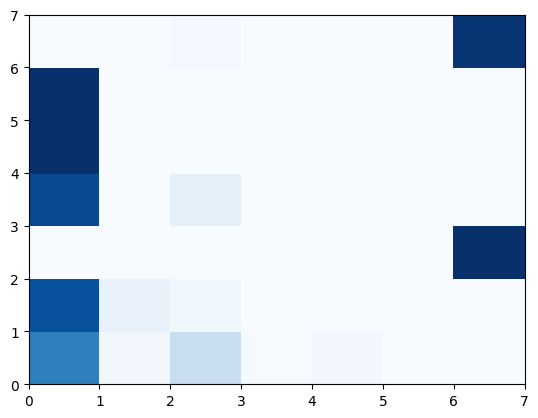

layer 1


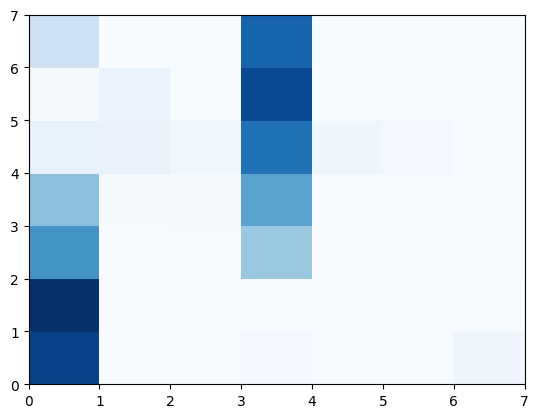

layer 2


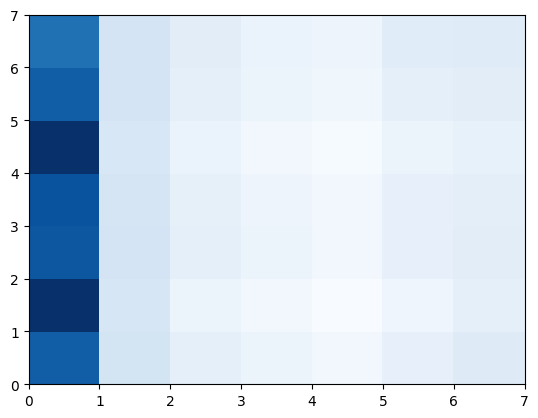

In [ ]:
for i in range(len(enc_slf_attns)):
    print("layer {}".format(i))
    plt.pcolor(enc_slf_attns[i][3].cpu().detach().numpy(), cmap=plt.cm.Blues)
    plt.show()

layer 0


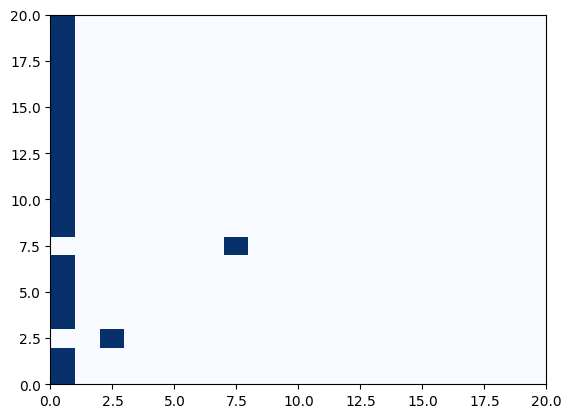

layer 1


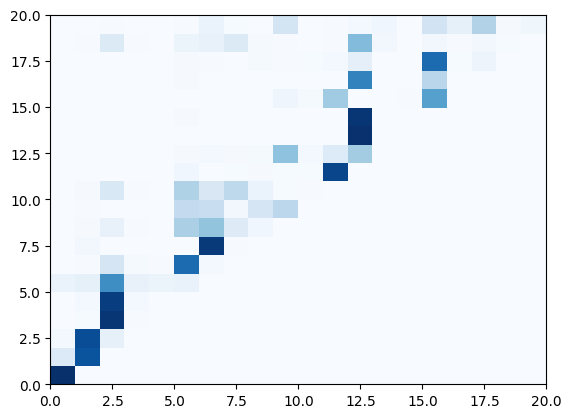

layer 2


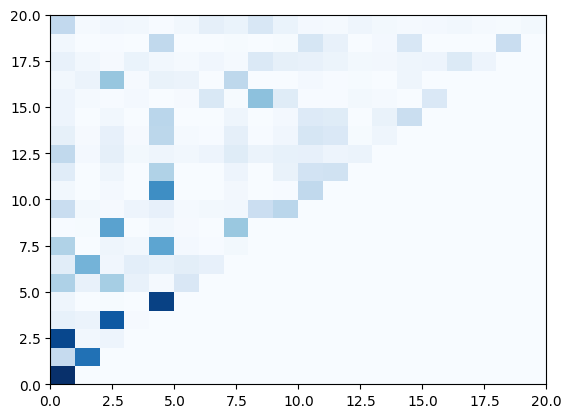

In [ ]:
for i in range(len(enc_slf_attns)):
    print("layer {}".format(i))
    plt.pcolor(dec_slf_attns[i][3].cpu().detach().numpy(), cmap=plt.cm.Blues)
    plt.show()